In [57]:
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt 
import scipy
from scipy.io.wavfile import read
from scipy.signal import spectrogram
import IPython.display as ipd
import torch as torch
import re
from tqdm import tqdm
from torch.utils.data import DataLoader

from torchsummary import summary

In [2]:
import os

_REP_PATH_ = '/Users/enzoben/Desktop/études/M2 MIA/Periode 1&2/Signal/Projet_source_separation'
train_small_dir = _REP_PATH_ + '/data/train_small'
train_dir = _REP_PATH_ + '/data/train'
test_dir = _REP_PATH_ + '/data/test'

# PROJET MVA - DLTS : Séparation de Sources

```
Enzo Benbalit
Abdellah Rebaine
```

# I. Analyse des données

## Importation des données

In [3]:
from extract_data import load_signal, interactive_spectrogramme, interactive_amplitude, plotlosses_history, SISDR_by_SNR

In [4]:
# Initialiser une liste pour stocker les informations
data_path = []
# Parcourir les sous-dossiers
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    if os.path.isdir(subdir_path):
        # Parcourir les fichiers dans le sous-dossier
        for file in os.listdir(subdir_path):
            if file.startswith("mix_snr_") and file.endswith(".wav"):
                # Extraire le SNR du nom du fichier
                match = re.search(r"mix_snr_(-?\d+).wav", file)
                if match:
                    snr_value = match.group(1)
                    # Ajouter les informations à la liste
                    data_path.append({'Nom': subdir, 'SNR': float(snr_value), 'Path': subdir_path})

train_df_path = pd.DataFrame(data_path)
print(f"Pour l'entraînement, on dispose d'un dataset comprenant {len(train_df_path)} signaux.")

Pour l'entraînement, on dispose d'un dataset comprenant 5000 signaux.


In [5]:
data = []

# Parcourir les sous-dossiers
for subdir in os.listdir(test_dir):
    subdir_path = os.path.join(test_dir, subdir)
    if os.path.isdir(subdir_path):
        # Parcourir les fichiers dans le sous-dossier
        for file in os.listdir(subdir_path):
            if file.startswith("mix_snr_") and file.endswith(".wav"):
                # Extraire le SNR du nom du fichier
                match = re.search(r"mix_snr_(-?\d+).wav", file)
                if match:
                    snr_value = match.group(1)
                    # Ajouter les informations à la liste
                    data.append({'Nom': subdir, 'SNR': float(snr_value), 'Path': subdir_path})

test_df_path = pd.DataFrame(data)

print(f"Pour le test, on dispose d'un dataset comprenant {len(test_df_path)} signaux.")

Pour le test, on dispose d'un dataset comprenant 2000 signaux.


## Distribution des SNR

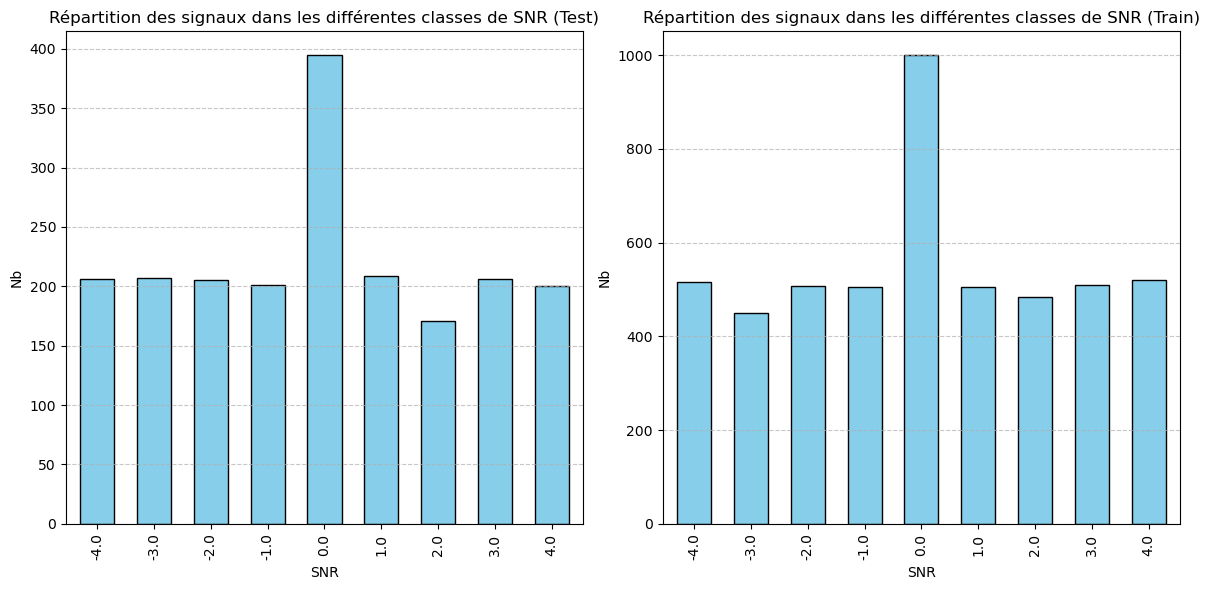

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  

test_df_path.groupby("SNR").count()["Nom"].plot(
    kind='bar',
    width=0.6,
    color="skyblue",
    edgecolor="black",
    legend=False,
    ax=axes[0]  
)
axes[0].set_xlabel("SNR")
axes[0].set_ylabel("Nb")
axes[0].set_title("Répartition des signaux dans les différentes classes de SNR (Test)")
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

train_df_path.groupby("SNR").count()["Nom"].plot(
    kind='bar',
    width=0.6,
    color="skyblue",
    edgecolor="black",
    legend=False,
    ax=axes[1] 
)
axes[1].set_xlabel("SNR")
axes[1].set_ylabel("Nb")
axes[1].set_title("Répartition des signaux dans les différentes classes de SNR (Train)")
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


> Ajouter un petit commentaire ? 

## Analyse de quelques signaux

### **Ecoute de quelques signaux pour différents SNR**

In [7]:
sample_snr0 = load_signal(train_df_path[train_df_path['SNR'] == 0].iloc[0]['Path'])
sample_snr4 = load_signal(train_df_path[train_df_path['SNR'] == 4].iloc[0]['Path'])
sample_snrn4 = load_signal(train_df_path[train_df_path['SNR'] == -4].iloc[0]['Path'])

In [8]:
print("Le signal mixte pour un SNR de 4 dB : ")
ipd.Audio(sample_snr4.mix['audio'], rate=sample_snr4.mix['fe'])

Le signal mixte pour un SNR de 4 dB : 


In [9]:
print("Le signal mixte pour un SNR de 0 dB : ")
ipd.Audio(sample_snr0.mix['audio'], rate=sample_snr0.mix['fe'])

Le signal mixte pour un SNR de 0 dB : 


In [10]:
print("Le signal mixte pour un SNR de -4 dB : ")
ipd.Audio(sample_snrn4.mix['audio'], rate=sample_snrn4.mix['fe'])

Le signal mixte pour un SNR de -4 dB : 


### **Amplitude dans le domaine temporelle**

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

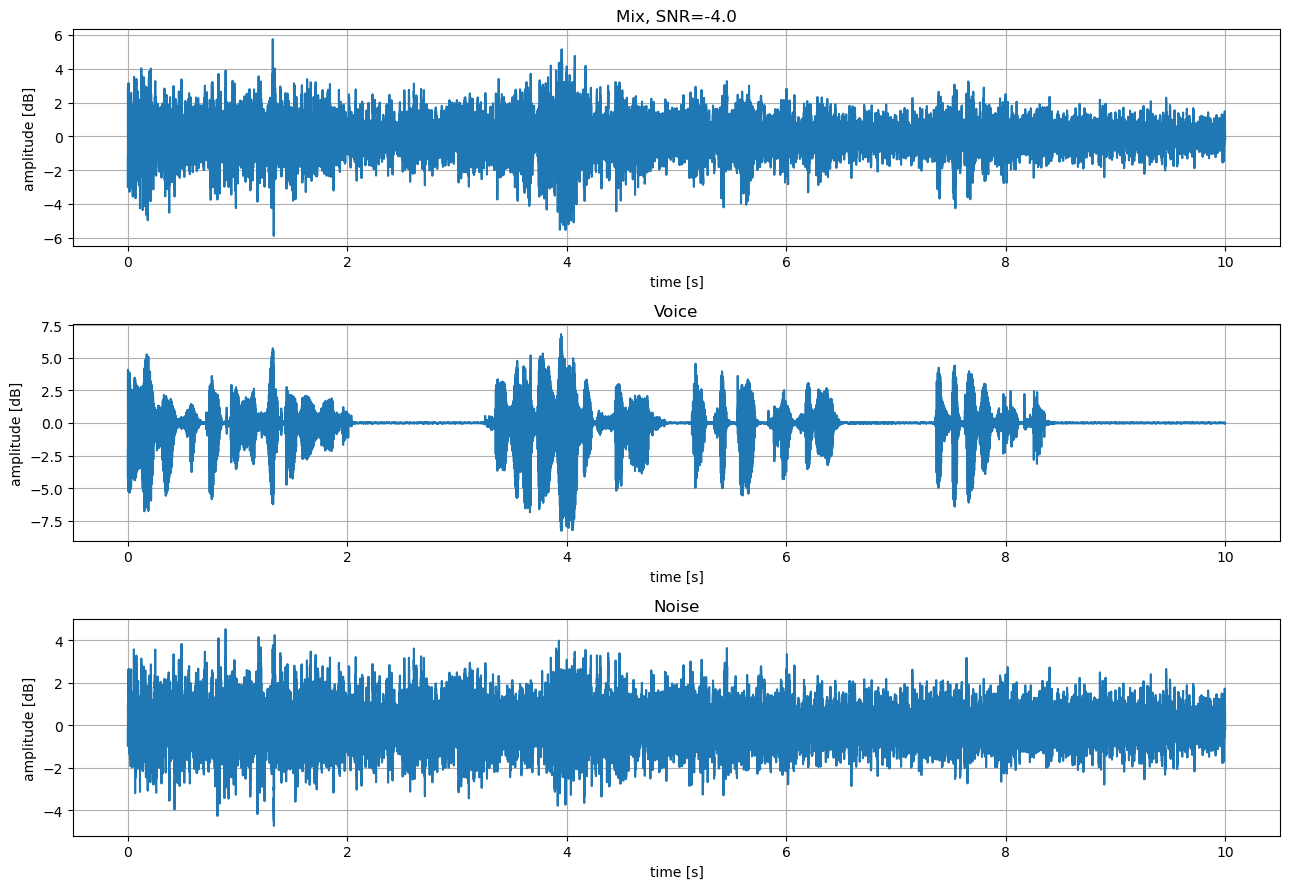

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

In [11]:
interactive_amplitude(train_df_path)

### **Spectrogramme des signaux pour différents SNR**

La taille de la fenêtre utilisée pour la STFT est un compromis entre résolution fréquentielle et résolution spectrale. Une grande fenêtre permettra une bonne résolution fréquentielle mais une mauvaise résolution temporelle. A l'inverse, une fenêtre trop petite conduit au risque de réaliser des transformées de Fourier sur des sous-signaux non stationnaires. 
Ici, nous avons décidé d'opter pour les paramètres les plus sastifaisant à vue d'oeil (sur les signaux "voice" uniquement), qui permettent d'avoir à la fois un nombre élevé de points sur la plage temporelle tout en gardant une certaine netteté et précision dans le domaine fréquenciel (visualisation des harmoniques etc...).

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

Dropdown(description='SNR:', options=(-4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0), value=-4.0)

Dropdown(description='Nom:', options=('0003', '0004', '0013', '0017', '0026', '0043', '0044', '0055', '0064', …

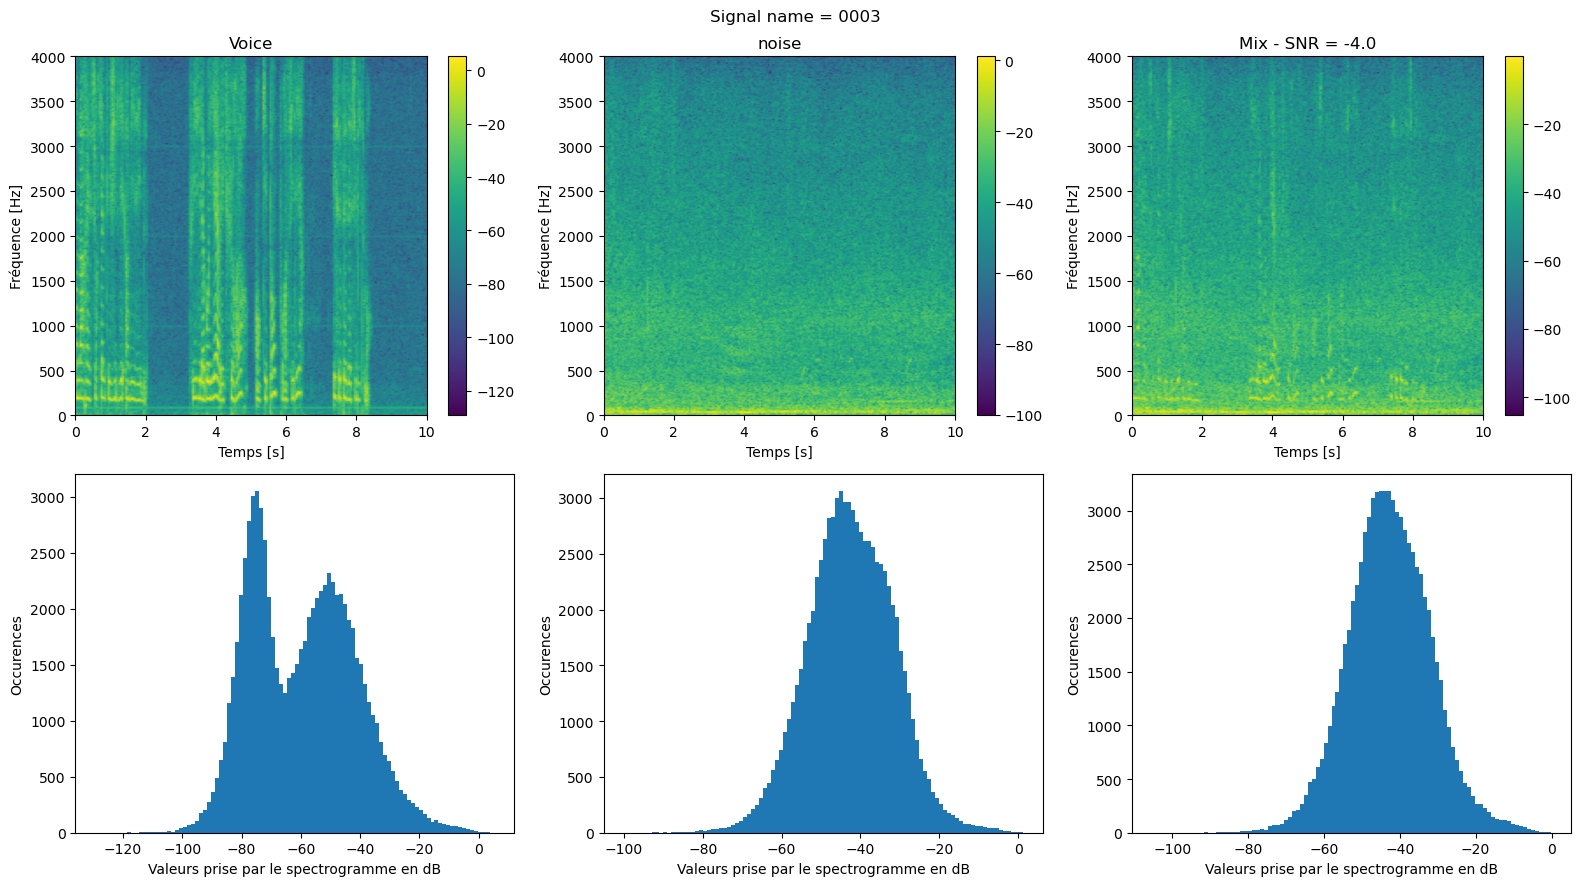

In [12]:
interactive_spectrogramme(train_df_path)

Pour la suite, lorsque nos modèles nécessitent une représentation temps - fréquence, nous utiliserons la fonction ```stft``` de pytorch, avec les paramètres suivants: 
- n_fft = 800
- window= torch.hann_window(800)
- return_complex = True

Ci dessous un exemple : 

In [13]:
signal_exemple = torch.tensor(sample_snr4.voice['audio'])
print(f"Le signal utilisé en exemple à les dimensions suivantes : {signal_exemple.shape}")

Le signal utilisé en exemple à les dimensions suivantes : torch.Size([80000])


In [14]:
Sxx_exemple = torch.stft(signal_exemple, n_fft=800, window=torch.hann_window(800), return_complex=True)
print(f"Le spectrogramme associé à notre signal 'exemple' à les dimensions suivantes : {Sxx_exemple.shape}")

Le spectrogramme associé à notre signal 'exemple' à les dimensions suivantes : torch.Size([401, 401])


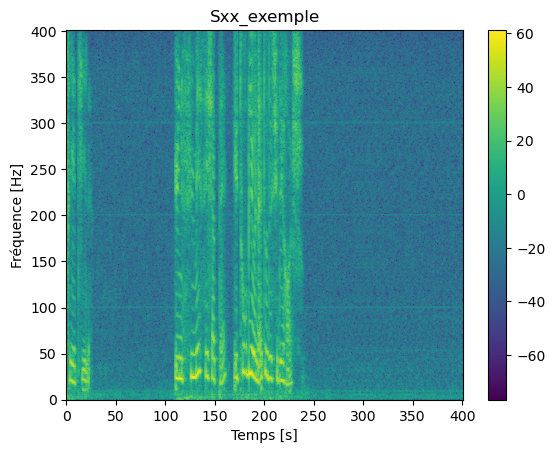

In [15]:
plt.figure()
mesh = plt.pcolormesh(20*np.log10(np.abs(np.array(Sxx_exemple))), cmap='viridis')
plt.colorbar(mesh) 
plt.title("Sxx_exemple")
plt.xlabel("Temps [s]")
plt.ylabel("Fréquence [Hz]")
plt.show()

L'objectif est maintenant d'entraîner différents modèles de deep learning pour séparer, en partant du signal mixte, les signaux voix et bruit. Pour ce faire, nous avons implémentés 4 modèles différents : 

> - Un modèle baseline, qui n'est autre qu'un encodeur (couches de convolutions 2D) décodeur (couches de déconvolutions 2D) sans interactions entre les deux parties (pas de concat)
> - Un modèle de type UNET basé sur le papier d'A. Jansson et Al., SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL NETWORK, ISMIR 2017
> - Un modèle de type Deep Clustering basé sur le papier de J.R. Hershey et Al., Deep clustering: Discriminative embeddings for segmentation and separation, ICASSP 2016
> - Un modèle de type Wave UNET basé sur le papier WAVE-U-NET: A MULTI-SCALE NEURAL NETWORK FOR END-TO-END AUDIO SOURCE SEPARATION, ISMIR 2018

Comme métrique d'évaluation (pour comparer les modèles en eux), nous utiliserons le Si-SDR. Pour entraîner les modèles, nous utiliserons deux loss : la MSE et la loss L1. Nous aurons l'occasion de comparer leurs performances.


## Les modèles de séparation de source

#### **Création d'une pipeline d'entraînement**

In [16]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [53]:
# Chargement des données
class Dataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data, n_fft = 800, return_spectrogram=True):
        super().__init__()
        self.path = path_to_data
        self.n_fft = n_fft
        self.length = len(os.listdir(path_to_data))
        self.return_spectrogram = return_spectrogram

    def __len__(self):
        return self.length

    def __getitem__(self,i):
        mixte, voice, noise = None, None, None
        Smixte, Svoice, Snoise = None, None, None
        str_i = str(i)
        while len(str_i) < 4:
            str_i = '0' + str_i
        path_to_sample = os.path.join(self.path, str_i)
        if self.return_spectrogram:
            if os.path.isdir(path_to_sample):
                for filename in os.listdir(path_to_sample):
                    path_to_file = os.path.join(path_to_sample, filename)
                    if filename.endswith(".wav"):
                        _, audio = read(path_to_file)
                        audio = audio/np.max(np.abs(audio))
                        audio/=np.std(audio)
                        audio = torch.tensor(audio)
                        if  "mix" in filename:
                            Smixte = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True).unsqueeze(0)
                        elif "noise" in  filename:
                            Snoise = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True).unsqueeze(0)
                        else:
                            Svoice = torch.stft(audio, n_fft=self.n_fft, window= torch.hann_window(self.n_fft), return_complex=True).unsqueeze(0)
            return (Smixte, Svoice, Snoise)
        else:
            if os.path.isdir(path_to_sample):
                for filename in os.listdir(path_to_sample):
                    path_to_file = os.path.join(path_to_sample, filename)
                    if filename.endswith(".wav"):
                        _, audio = read(path_to_file)
                        audio = audio/np.max(np.abs(audio))
                        audio/=np.std(audio)
                        audio = torch.tensor(audio)
                        if  "mix" in filename:
                            mixte = audio
                        elif "noise" in  filename:
                            noise = audio
                        else:
                            voice = audio
            return (mixte, voice, noise)

In [18]:
def train(device, model, train_data, validation_data, optimizer, criterion, mode, n_epoch, path_save):
    model.to(device)
    hist_loss_train = []
    hist_loss_valid = []
    for epoch in range(n_epoch):
        # Training phase
        model.train()
        train_loss = 0
        num_samples=0
        dloader_train = tqdm(train_data, unit='batches')
        for i, (batch_Smixte, batch_Svoice, batch_Snoise) in enumerate(dloader_train, start=1):
            batch_Smixte, batch_Svoice, batch_Snoise = torch.abs(batch_Smixte.to(device)), torch.abs(batch_Svoice.to(device)), torch.abs(batch_Snoise.to(device))
            optimizer.zero_grad()
            if mode == "voice":
                pred_Svoice = model(batch_Smixte)
                loss = criterion(pred_Svoice,batch_Svoice)
            elif mode == "noise":
                pred_Snoise = model(batch_Smixte)
                loss = criterion(pred_Snoise,batch_Snoise)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*len(batch_Smixte)
            num_samples+=len(batch_Smixte)
            desc = "TRAIN : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, n_epoch, train_loss/num_samples)
            dloader_train.set_description(desc)
        hist_loss_train.append(train_loss/num_samples)
        # Validation phase
        model.eval()
        valid_loss = 0
        num_samples=0
        dloader_valid = tqdm(validation_data, unit='batches')
        for i, (batch_Smixte, batch_Svoice, batch_Snoise) in enumerate(dloader_valid, start=1):
            batch_Smixte, batch_Svoice, batch_Snoise = torch.abs(batch_Smixte.to(device)), torch.abs(batch_Svoice.to(device)), torch.abs(batch_Snoise.to(device))
            with torch.no_grad():
                if mode == "voice":
                    pred_Svoice = model(batch_Smixte)
                    loss = criterion(pred_Svoice,batch_Svoice)
                elif mode == "noise":
                    pred_Snoise = model(batch_Smixte)
                    loss = criterion(pred_Snoise,batch_Snoise)
                valid_loss += loss.item()*len(batch_Smixte)
                num_samples+=len(batch_Smixte)
                desc = "VALIDATION : Epoch [{}/{}] - loss : {:.3f} ".format(epoch+1, n_epoch, valid_loss/num_samples)
                dloader_valid.set_description(desc)
        hist_loss_valid.append(valid_loss/num_samples)
        torch.save(model,_REP_PATH_ + '/DLTS-PROJECT/trained_models/{}/'.format(path_save) +'{}_{}'.format(path_save, mode)+'.pth')
        pd.DataFrame({
        'train_loss' : hist_loss_train,
        'valid_loss' : hist_loss_valid}).to_csv(_REP_PATH_ +'/DLTS-PROJECT/trained_models/{}/'.format(path_save)+'{}_{}'.format(path_save, mode)+'.csv')

### **1. Baseline**

In [19]:
train_data_spec = Dataset(train_dir, n_fft= 800, return_spectrogram= True)
test_data_spec = Dataset(test_dir, n_fft= 800, return_spectrogram=True)
valid_data_spec = Dataset(train_small_dir, n_fft= 800, return_spectrogram=True)

In [20]:
# Creation of the dataloaders
batch_size = 10
dataloader_train = DataLoader(train_data_spec,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_test = DataLoader(test_data_spec,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_valid = DataLoader(valid_data_spec,
                        batch_size= batch_size,
                        shuffle=False
                       )

Ajouter un schéma explicatif du modèle baseline

In [59]:
from models.BASELINE import BASELINE

baseline_voice = BASELINE(n_input_channel=1, n_output_channel=1, kernel_size=5, stride=2, padding=0)
optimizer_voice = torch.optim.Adam(baseline_voice.parameters())
loss_voice= torch.nn.L1Loss()
path_save_voice = ""

baseline_noise = BASELINE(n_input_channel=1, n_output_channel=1, kernel_size=5, stride=2, padding=0)
optimizer_noise = torch.optim.Adam(baseline_noise.parameters())
loss_noise = torch.nn.L1Loss()
path_save_noise = ""

n_epochs = 20

In [60]:
summary(baseline_voice, input_size=(1,401,401))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 199, 199]             416
       BatchNorm2d-2         [-1, 16, 199, 199]              32
         LeakyReLU-3         [-1, 16, 199, 199]               0
  EncoderConvBlock-4  [[-1, 16, 199, 199], [-1, 16, 199, 199]]               0
            Conv2d-5           [-1, 32, 98, 98]          12,832
       BatchNorm2d-6           [-1, 32, 98, 98]              64
         LeakyReLU-7           [-1, 32, 98, 98]               0
  EncoderConvBlock-8  [[-1, 32, 98, 98], [-1, 32, 98, 98]]               0
            Conv2d-9           [-1, 64, 47, 47]          51,264
      BatchNorm2d-10           [-1, 64, 47, 47]             128
        LeakyReLU-11           [-1, 64, 47, 47]               0
 EncoderConvBlock-12  [[-1, 64, 47, 47], [-1, 64, 47, 47]]               0
           Conv2d-13          [-1, 128, 22, 22]         204,928
  

In [22]:
# train(device=device,
#       model = baseline_voice,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_voice,
#       criterion = loss_voice,
#       mode="voice",
#       path_save="baseline",
#       n_epoch=15)

# train(device=device,
#       model = baseline_noise,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_noise,
#       criterion = loss_noise,
#       mode="noise",
#       path_save="baseline",
#       n_epoch=15)


In [23]:
baseline_voice = torch.load(_REP_PATH_+'/DLTS-PROJECT/trained_models/baseline/baseline_voice.pth', map_location="cpu")
baseline_loss_history = pd.read_csv(_REP_PATH_+'/DLTS-PROJECT/trained_models/baseline/baseline_voice.csv')

/var/folders/w7/qbmvl3jn1bjc4wk95vsp_vx00000gn/T/ipykernel_77678/1023899604.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  baseline_voice = torch.load(_REP_PATH_+'/DLTS

#### **Évolution de la loss pour l'entrainement**

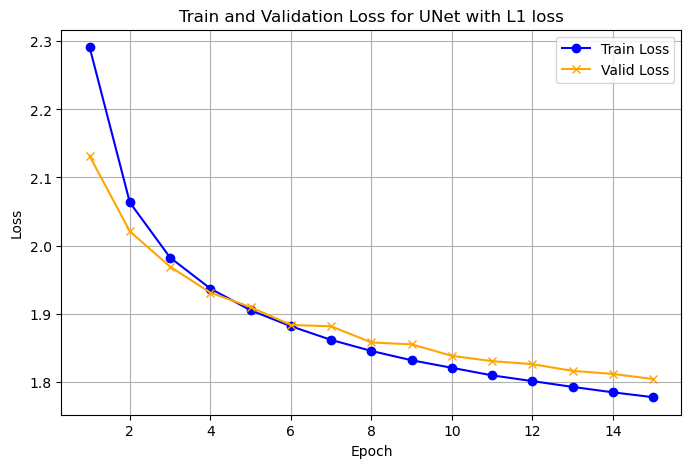

In [24]:
plotlosses_history(baseline_loss_history)

#### **SI-SDR en fonction des SNR**

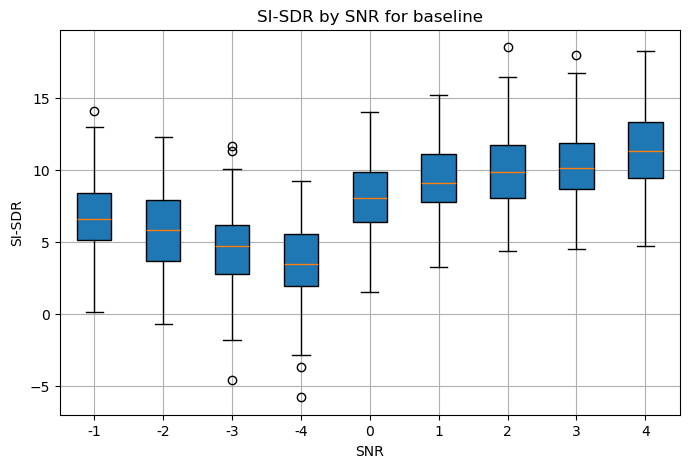

In [33]:
sisdr_by_snr = {}
sisdr_by_snr["baseline"] = SISDR_by_SNR(baseline_voice, test_df_path, model_name="baseline", device="mps")

#### **Observation de la forme d'onde du signal reconstruit**

In [ ]:
# def plot_reconstruction(model, test_df_path, device = "cpu"):

path_to_signal = test_dir + '/0000'

signal = load_signal(path_to_signal)

Smix = torch.stft(torch.tensor(signal.mix["audio"]), n_fft = 800, window = torch.hann_window(800), return_complex = True).unsqueeze(0).to(device)
Svoice = torch.stft(torch.tensor(signal.voice["audio"]), n_fft = 800, window = torch.hann_window(800), return_complex = True).unsqueeze(0).to(device)

Smix_ampl = torch.abs(Smix)
Svoice_ampl = torch.abs(Svoice)
mask = baseline_voice(Smix_ampl.unsqueeze(0))
svoice_reconst = mask*Smix/Smix_ampl

audio = torch.istft(svoice_reconst[0,0,:,:].to('cpu'), n_fft = 800, window=torch.hann_window(800))


fig, axes = plt.subplots(2,2, figsize = (12,9))

pcm = axes[0,0].pcolormesh()

# ipd.Audio(audio.detach().numpy(), rate = 8000)

### **UNet**

In [25]:
from models.UNET import UNet

In [62]:
unet_voice = UNet(n_input_channel=1, n_output_channel=1)
optimizer_voice = torch.optim.Adam(unet_voice.parameters())
loss_voice= torch.nn.L1Loss()
path_save_voice = ""

unet_noise = UNet(n_input_channel=1, n_output_channel=1)
optimizer_noise = torch.optim.Adam(unet_noise.parameters())
loss_noise= torch.nn.L1Loss()
path_save_noise = ""

In [63]:
summary(unet_voice, input_size= (1,401,401))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 199, 199]             416
       BatchNorm2d-2         [-1, 16, 199, 199]              32
         LeakyReLU-3         [-1, 16, 199, 199]               0
  EncoderConvBlock-4  [[-1, 16, 199, 199], [-1, 16, 199, 199]]               0
            Conv2d-5           [-1, 32, 98, 98]          12,832
       BatchNorm2d-6           [-1, 32, 98, 98]              64
         LeakyReLU-7           [-1, 32, 98, 98]               0
  EncoderConvBlock-8  [[-1, 32, 98, 98], [-1, 32, 98, 98]]               0
            Conv2d-9           [-1, 64, 47, 47]          51,264
      BatchNorm2d-10           [-1, 64, 47, 47]             128
        LeakyReLU-11           [-1, 64, 47, 47]               0
 EncoderConvBlock-12  [[-1, 64, 47, 47], [-1, 64, 47, 47]]               0
           Conv2d-13          [-1, 128, 22, 22]         204,928
  

In [28]:
# train(device=device,
#       model = unet_voice,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_voice,
#       criterion = loss_voice,
#       mode="voice",
#       path_save="unet",
#       n_epoch=15)

# train(device=device,
#       model = unet_noise,
#       train_data=dataloader_train,
#       validation_data=dataloader_valid,
#       optimizer=optimizer_noise,
#       criterion = loss_noise,
#       mode="noise",
#       path_save="unet",
#       n_epoch=15)

In [29]:
unet_voice = torch.load(_REP_PATH_+'/DLTS-PROJECT/trained_models/unet/unet_voice.pth')
unet_loss_history = pd.read_csv(_REP_PATH_+'/DLTS-PROJECT/trained_models/unet/unet_voice.csv')

/var/folders/w7/qbmvl3jn1bjc4wk95vsp_vx00000gn/T/ipykernel_77678/1881647926.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet_voice = torch.load(_REP_PATH_+'/DLTS-PRO

#### **Évolution de la loss pour l'entrainement**

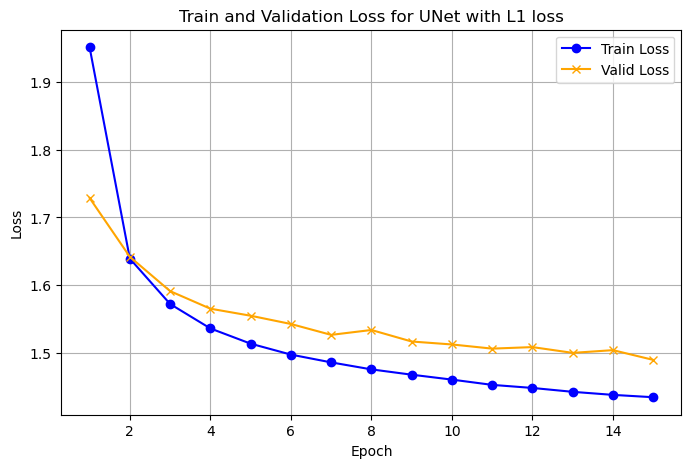

In [30]:
plotlosses_history(unet_loss_history)

#### **SI-SDR en fonction des SNR**

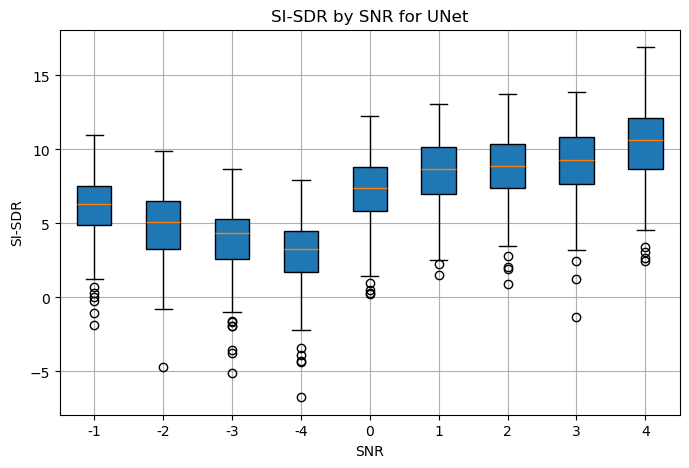

In [34]:
sisdr_by_snr["unet"] = SISDR_by_SNR(unet_voice, test_df_path, model_name="UNet", device = device)

### **Wave UNet**

In [55]:
train_data_audio = Dataset(train_dir, return_spectrogram= False)
test_data_audio = Dataset(test_dir, return_spectrogram=False)
valid_data_audio = Dataset(train_small_dir, return_spectrogram=False)

In [56]:
batch_size = 10
dataloader_train_audio = DataLoader(train_data_audio,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_test_audio = DataLoader(test_data_audio,
                        batch_size= batch_size,
                        shuffle=True
                       )
dataloader_valid_audio = DataLoader(valid_data_audio,
                        batch_size= batch_size,
                        shuffle=True
                       )

In [51]:
from models.WAVEUNET import WaveUNet

In [ ]:
waveunet_model = WaveUNet()